# load training result

[http://cv-tricks.com/tensorflow-tutorial/save-restore-tensorflow-models-quick-complete-tutorial/](http://cv-tricks.com/tensorflow-tutorial/save-restore-tensorflow-models-quick-complete-tutorial/)

In [1]:
import tensorflow as tf
from PIL import Image
import glob
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
IMAGE_HEIGHT = 200
IMAGE_WIDTH = 320
NUM_CHANNELS = 3
BATCH_SIZE = 5
labels =["mesa", "forest","desert","jungle", "eh"]

In [3]:
checkpoint_file = "/notebooks/Minecraft-AI/mc-data/model/model.ckpt"

In [4]:
sess = tf.InteractiveSession()
sess.as_default()
saver = tf.train.import_meta_graph("{}.meta".format(checkpoint_file))
saver.restore(sess,checkpoint_file )#, tf.train.latest_checkpoint('/notebooks/Minecraft-AI/mc-data/model/'))
tf.global_variables_initializer().run()

INFO:tensorflow:Restoring parameters from /notebooks/Minecraft-AI/mc-data/model/model.ckpt


In [5]:
graph = tf.get_default_graph()

In [6]:
test_data_node = graph.get_operation_by_name("test_data_node").outputs[0]
test_prediction = graph.get_operation_by_name("test_prediction").outputs[0]

In [7]:
def scaleImg(img):
    img = np.array(Image.open(img)).astype(np.float32)
#     img = img.astype(np.float32)
    return (img-(255/2.0)) / 255

In [8]:
def scaleImgs(img_dir):
    img_files = glob.glob(img_dir)[:BATCH_SIZE]
    data = np.array([scaleImg(img) for img in img_files])
    return data

In [25]:
img_path= "/notebooks/Minecraft-AI/mc-data/forest_splited/006/*.jpg"
batch_data = scaleImgs(img_path)

In [26]:
predictions = sess.run([test_prediction],
              feed_dict={test_data_node:batch_data})[0]
predictions = np.argmax(predictions, 1)

In [27]:
maj = np.bincount(predictions).argmax() # get majority

majority:  forest


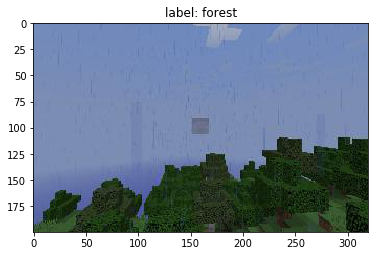

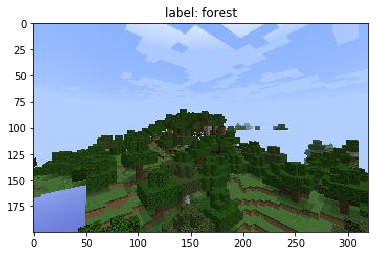

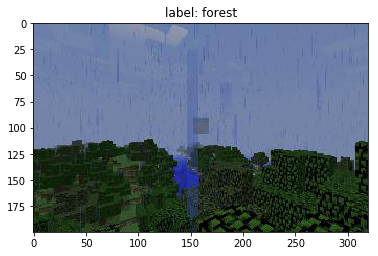

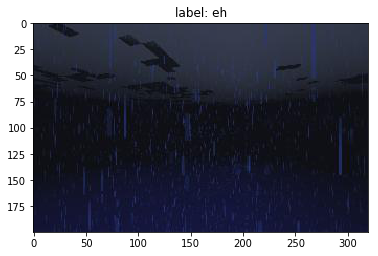

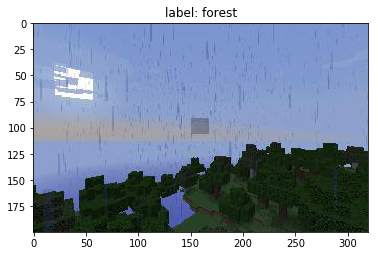

In [28]:
img_files = glob.glob(img_path)[:BATCH_SIZE]
print "majority: ", labels[maj]
for i, img in enumerate(img_files):
    plt.figure()
    plt.title("label: {}".format(labels[predictions[i]]))
    plt.imshow(Image.open(img))
    plt.plot()

In [30]:
sess.close()